# DenseNet121 Training & Evaluation Notebook

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1762 files belonging to 5 classes.
Found 250 files belonging to 5 classes.
Found 509 files belonging to 5 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,301,189 (27.85 MB)

 Trainable params: 263,685 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2926 - loss: 1.7286

111/111 ━━━━━━━━━━━━━━━━━━━━ 602s 5s/step - accuracy: 0.2932 - loss: 1.7269 - val_accuracy: 0.6560 - val_loss: 1.0296 - learning_rate: 1.0000e-04
Epoch 2/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.5536 - loss: 1.1414

111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 332ms/step - accuracy: 0.5543 - loss: 1.1401 - val_accuracy: 0.7200 - val_loss: 0.8189 - learning_rate: 1.0000e-04
Epoch 3/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6640 - loss: 0.8972

111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 332ms/step - accuracy: 0.6641 - loss: 0.8967 - val_accuracy: 0.7600 - val_loss: 0.6937 - learning_rate: 1.0000e-04
Epoch 4/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7146 - loss: 0.7737

111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 325ms/step - accuracy: 0.7148 - loss: 0.7735 - val_accuracy: 0.7840 - val_loss: 0.6324 - learning_rate: 1.0000e-04
Epoch 5/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.7592 - loss: 0.6724

111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 327ms/step - accuracy: 0.7591 - loss: 0.6723 - val_accuracy: 0.8000 - val_loss: 0.5927 - learning_rate: 1.0000e-04
Epoch 6/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.7982 - loss: 0.5856

111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 336ms/step - accuracy: 0.7982 - loss: 0.5857 - val_accuracy: 0.8040 - val_loss: 0.5634 - learning_rate: 1.0000e-04
Epoch 7/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.7729 - loss: 0.5873

111/111 ━━━━━━━━━━━━━━━━━━━━ 39s 352ms/step - accuracy: 0.7732 - loss: 0.5871 - val_accuracy: 0.8320 - val_loss: 0.5089 - learning_rate: 1.0000e-04
Epoch 8/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 34s 307ms/step - accuracy: 0.7882 - loss: 0.5507 - val_accuracy: 0.8360 - val_loss: 0.5105 - learning_rate: 1.0000e-04
Epoch 9/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8152 - loss: 0.5205

111/111 ━━━━━━━━━━━━━━━━━━━━ 44s 333ms/step - accuracy: 0.8154 - loss: 0.5202 - val_accuracy: 0.8360 - val_loss: 0.4755 - learning_rate: 1.0000e-04
Epoch 10/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8195 - loss: 0.4866

111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 326ms/step - accuracy: 0.8196 - loss: 0.4865 - val_accuracy: 0.8280 - val_loss: 0.4665 - learning_rate: 1.0000e-04
Epoch 11/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8429 - loss: 0.4418

111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 332ms/step - accuracy: 0.8430 - loss: 0.4418 - val_accuracy: 0.8480 - val_loss: 0.4508 - learning_rate: 1.0000e-04
Epoch 12/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8405 - loss: 0.4462

111/111 ━━━━━━━━━━━━━━━━━━━━ 41s 331ms/step - accuracy: 0.8405 - loss: 0.4460 - val_accuracy: 0.8560 - val_loss: 0.4335 - learning_rate: 1.0000e-04
Epoch 13/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8444 - loss: 0.4400

111/111 ━━━━━━━━━━━━━━━━━━━━ 38s 342ms/step - accuracy: 0.8444 - loss: 0.4400 - val_accuracy: 0.8560 - val_loss: 0.4289 - learning_rate: 1.0000e-04
Epoch 14/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8450 - loss: 0.3964

111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 332ms/step - accuracy: 0.8450 - loss: 0.3967 - val_accuracy: 0.8440 - val_loss: 0.4228 - learning_rate: 1.0000e-04
Epoch 15/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8535 - loss: 0.4066

111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 327ms/step - accuracy: 0.8536 - loss: 0.4063 - val_accuracy: 0.8600 - val_loss: 0.4191 - learning_rate: 1.0000e-04
Epoch 16/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 318ms/step - accuracy: 0.8537 - loss: 0.3866 - val_accuracy: 0.8600 - val_loss: 0.4267 - learning_rate: 1.0000e-04
Epoch 17/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 39s 303ms/step - accuracy: 0.8475 - loss: 0.3813 - val_accuracy: 0.8520 - val_loss: 0.4218 - learning_rate: 1.0000e-04
Epoch 18/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.8786 - loss: 0.3640

111/111 ━━━━━━━━━━━━━━━━━━━━ 43s 324ms/step - accuracy: 0.8785 - loss: 0.3642 - val_accuracy: 0.8600 - val_loss: 0.4123 - learning_rate: 1.0000e-04
Epoch 19/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8794 - loss: 0.3576

111/111 ━━━━━━━━━━━━━━━━━━━━ 38s 338ms/step - accuracy: 0.8794 - loss: 0.3574 - val_accuracy: 0.8400 - val_loss: 0.4078 - learning_rate: 1.0000e-04
Epoch 20/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8819 - loss: 0.3367

111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 332ms/step - accuracy: 0.8820 - loss: 0.3366 - val_accuracy: 0.8600 - val_loss: 0.3904 - learning_rate: 1.0000e-04
Epoch 21/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 321ms/step - accuracy: 0.8810 - loss: 0.3247 - val_accuracy: 0.8640 - val_loss: 0.4089 - learning_rate: 1.0000e-04
Epoch 22/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 313ms/step - accuracy: 0.8735 - loss: 0.3432 - val_accuracy: 0.8640 - val_loss: 0.4153 - learning_rate: 1.0000e-04
Epoch 23/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.8848 - loss: 0.3141

111/111 ━━━━━━━━━━━━━━━━━━━━ 43s 331ms/step - accuracy: 0.8848 - loss: 0.3141 - val_accuracy: 0.8600 - val_loss: 0.3886 - learning_rate: 1.0000e-04
Epoch 24/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.8848 - loss: 0.3275

111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 333ms/step - accuracy: 0.8850 - loss: 0.3271 - val_accuracy: 0.8640 - val_loss: 0.3767 - learning_rate: 1.0000e-04
Epoch 25/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 34s 306ms/step - accuracy: 0.8976 - loss: 0.3010 - val_accuracy: 0.8560 - val_loss: 0.3857 - learning_rate: 1.0000e-04
Epoch 26/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 35s 315ms/step - accuracy: 0.9033 - loss: 0.2967 - val_accuracy: 0.8600 - val_loss: 0.3818 - learning_rate: 1.0000e-04
Epoch 27/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9094 - loss: 0.2520

111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 325ms/step - accuracy: 0.9093 - loss: 0.2523 - val_accuracy: 0.8640 - val_loss: 0.3648 - learning_rate: 1.0000e-04
Epoch 28/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 34s 308ms/step - accuracy: 0.8938 - loss: 0.2934 - val_accuracy: 0.8600 - val_loss: 0.4103 - learning_rate: 1.0000e-04
Epoch 29/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 35s 312ms/step - accuracy: 0.8838 - loss: 0.3191 - val_accuracy: 0.8640 - val_loss: 0.4039 - learning_rate: 1.0000e-04
Epoch 30/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 34s 306ms/step - accuracy: 0.9025 - loss: 0.2723 - val_accuracy: 0.8680 - val_loss: 0.3661 - learning_rate: 1.0000e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━

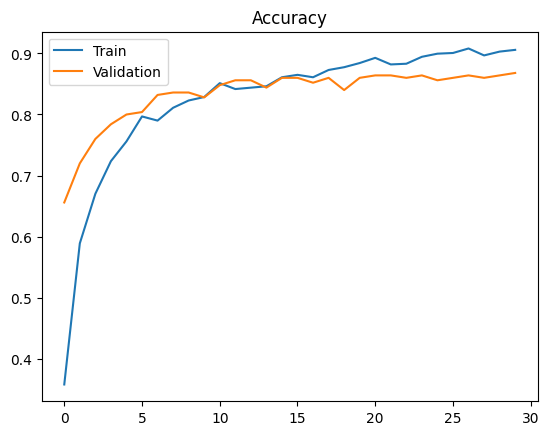

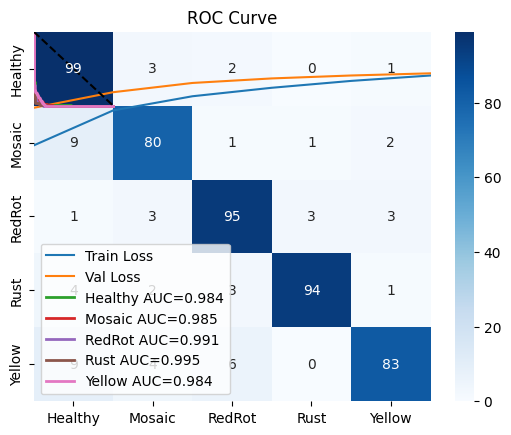

In [ ]:
# DenseNet121 Training & Evaluation Notebook

from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, matthews_corrcoef,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from itertools import cycle

# ---- CONFIG ----
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-4
NUM_CLASSES = 5

TRAIN_DIR = "/content/drive/MyDrive/Sugarcane Disease/dataset_split/train"
VAL_DIR   = "/content/drive/MyDrive/Sugarcane Disease/dataset_split/val"
TEST_DIR  = "/content/drive/MyDrive/Sugarcane Disease/dataset_split/test"

OUTPUT_DIR = f"/content/drive/MyDrive/DenseNet121_Results_Update"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---- DATASETS ----
train_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15)
])

train_ds = image_dataset_from_directory(TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True)
val_ds   = image_dataset_from_directory(VAL_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)
test_ds  = image_dataset_from_directory(TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.class_names

def preprocess(images, labels):
    images = train_augment(images)
    return preprocess_input(images), labels

train_ds = train_ds.map(preprocess)
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds  = test_ds.map(lambda x, y: (preprocess_input(x), y))

# ---- MODEL ----
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False

model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=4, factor=0.5),
    keras.callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/best_model.h5", save_best_only=True),
    keras.callbacks.CSVLogger(f"{OUTPUT_DIR}/train_log.csv")
]

# ---- TRAIN ----
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

# ---- SAVE MODEL + WEIGHTS (İKİSİ DE EKLENDİ!) ----
model.save(f"{OUTPUT_DIR}/final_model.h5")  # TAM MODEL
model.save_weights(f"{OUTPUT_DIR}/denseNet121_final_model.weights.h5")  # SADECE AĞIRLIK

# ---- LEARNING CURVES ----
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.legend(); plt.title("Accuracy")
plt.savefig(f"{OUTPUT_DIR}/accuracy_plot.png")

plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")
plt.savefig(f"{OUTPUT_DIR}/loss_plot.png")

# ---- TEST EVALUATION ----
y_true, y_pred, y_prob = [], [], []

for x, y in test_ds:
    p = model.predict(x)
    y_prob.extend(p)
    y_pred.extend(np.argmax(p, axis=1))
    y_true.extend(y.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="macro")
rec = recall_score(y_true, y_pred, average="macro")
f1  = f1_score(y_true, y_pred, average="macro")

with open(f"{OUTPUT_DIR}/metrics_report.txt", "w") as f:
    f.write(f"Accuracy: {acc}\nBalanced Accuracy: {bacc}\nMCC: {mcc}\nPrecision: {prec}\nRecall: {rec}\nF1 Score: {f1}\n")
    f.write(classification_report(y_true, y_pred, target_names=class_names))

# ---- CONFUSION MATRIX ----
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")

# ---- ROC CURVE ----
y_true_bin = keras.utils.to_categorical(y_true, NUM_CLASSES)

fpr, tpr, roc_auc = {}, {}, {}

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} AUC={roc_auc[i]:.3f}")

plt.plot([0,1],[0,1],'k--')
plt.legend(); plt.title("ROC Curve")
plt.savefig(f"{OUTPUT_DIR}/roc_curve.png")
